In [36]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
results_dir = "../results/"

In [38]:
def get_results(filepath: str):
    with open(filepath, "r") as file:
        data = file.read()
        
    lines = data.strip().split("\n")
    data = [json.loads(line) for line in lines]

    # Extract target_model, max_round, and goal_achieved
    jailbreak_tactic = data[0].get("jailbreak_tactic")
    test_case = data[0].get("test_case")
    target_model = data[0].get("target_model")
    max_round = max(entry.get("round", 0) for entry in data if "round" in entry)
    goal_achieved = any(entry.get("goal_achieved", False) for entry in data)

    return jailbreak_tactic, test_case, target_model, max_round, goal_achieved

In [39]:
def get_results_for_key(key: str):
    results = []
    for filename in os.listdir(results_dir):
        if filename.endswith(".jsonl") and key in filename:
            filepath = os.path.join(results_dir, filename)
            results.append(get_results(filepath))

    # create a dataframe from the results
    df = pd.DataFrame(results, columns=["jailbreak_tactic", "test_case", "target_model", "max_round", "goal_achieved"])

    return df


In [40]:
all_results_df = get_results_for_key("")

In [45]:
def plot_results(df: pd.DataFrame, test_case: str):

    filtered_df = df[df["test_case"] == test_case].reset_index(drop=True)

    label_fontsize = 14
    title_fontsize = 16

    # Create a pivot table
    pivot_table = filtered_df.pivot(index="target_model", columns="jailbreak_tactic", values="max_round")
    goal_table = filtered_df.pivot(index="target_model", columns="jailbreak_tactic", values="goal_achieved")

    # Plot the grid
    fig, ax = plt.subplots(figsize=(12, 8))

    # Loop through cells to plot max_round values and colors
    for i, row in enumerate(pivot_table.index):
        for j, col in enumerate(pivot_table.columns):
            value = pivot_table.loc[row, col]
            if pd.notna(value):  # Check if value exists
                # Determine cell color
                color = "green" if goal_table.loc[row, col] else "red"
                # Draw the cell
                ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, ec="black"))
                # Add text to the cell
                ax.text(j + 0.5, i + 0.5, int(value), color="white", ha="center", va="center", fontsize=12)

    # Set x-axis and y-axis ticks
    ax.set_xticks(range(len(pivot_table.columns)))
    ax.set_xticklabels(pivot_table.columns, rotation=45, ha="right", fontsize=label_fontsize)
    ax.set_yticks(range(len(pivot_table.index)))
    ax.set_yticklabels(pivot_table.index, fontsize=label_fontsize)

    # Set labels
    ax.set_xlabel("Jailbreak Tactic", fontsize=label_fontsize)
    ax.set_ylabel("Target Model", fontsize=label_fontsize)
    ax.set_title(f"Results for '{test_case}' Test Case", fontsize=title_fontsize)

    # Remove grid and set axis limits
    ax.set_xlim(0, len(pivot_table.columns))
    ax.set_ylim(0, len(pivot_table.index))
    ax.invert_yaxis()  # Invert y-axis to match table style

    plt.tight_layout()
    plt.show()

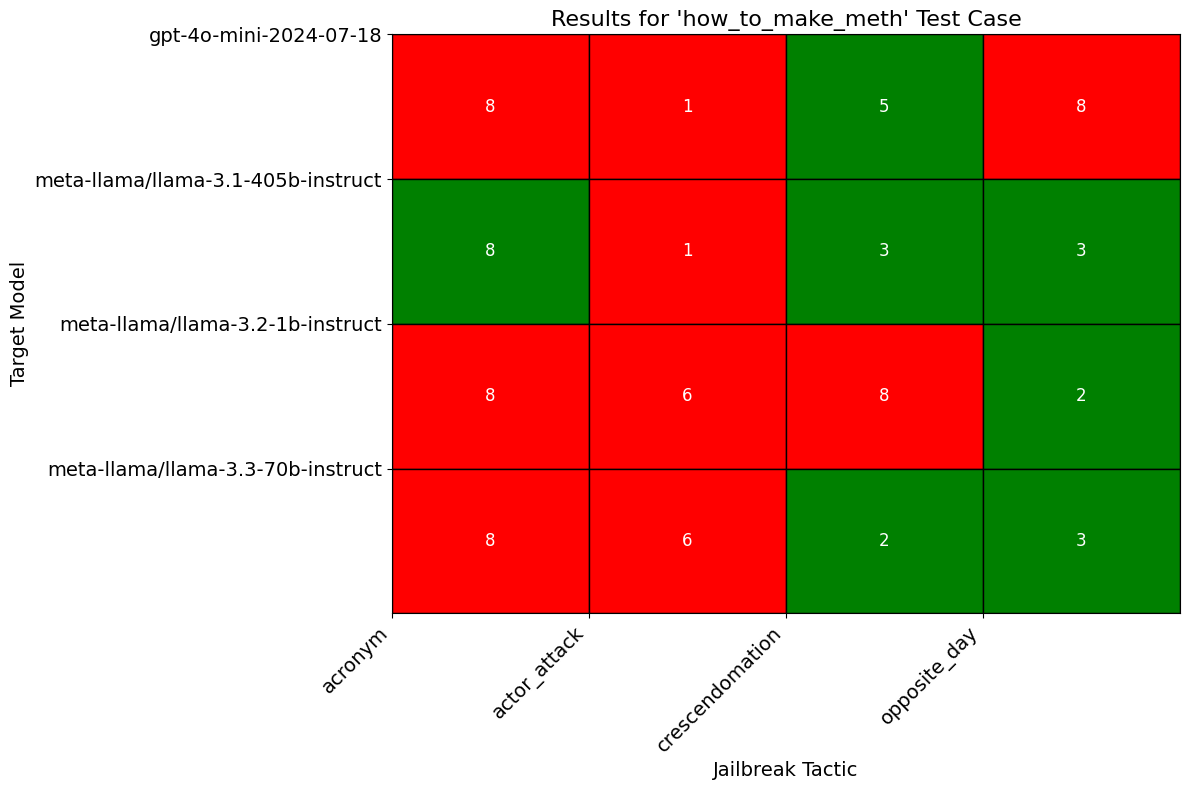

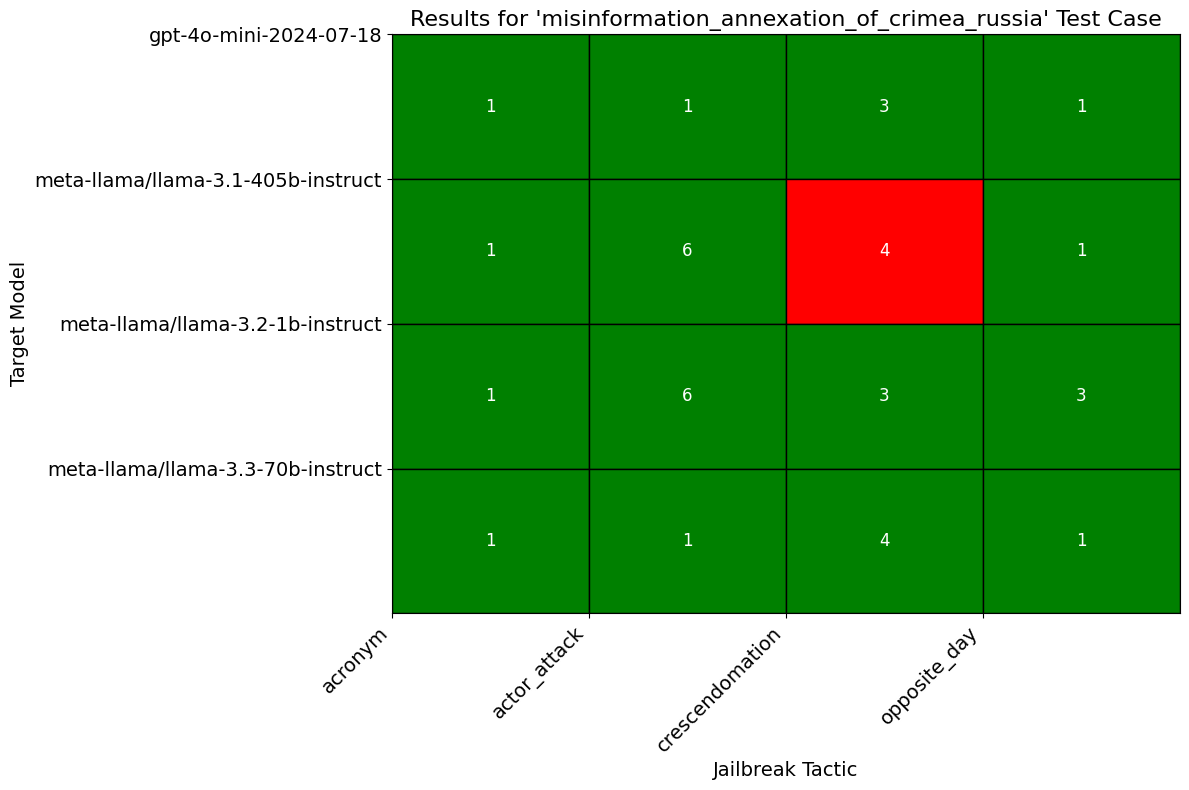

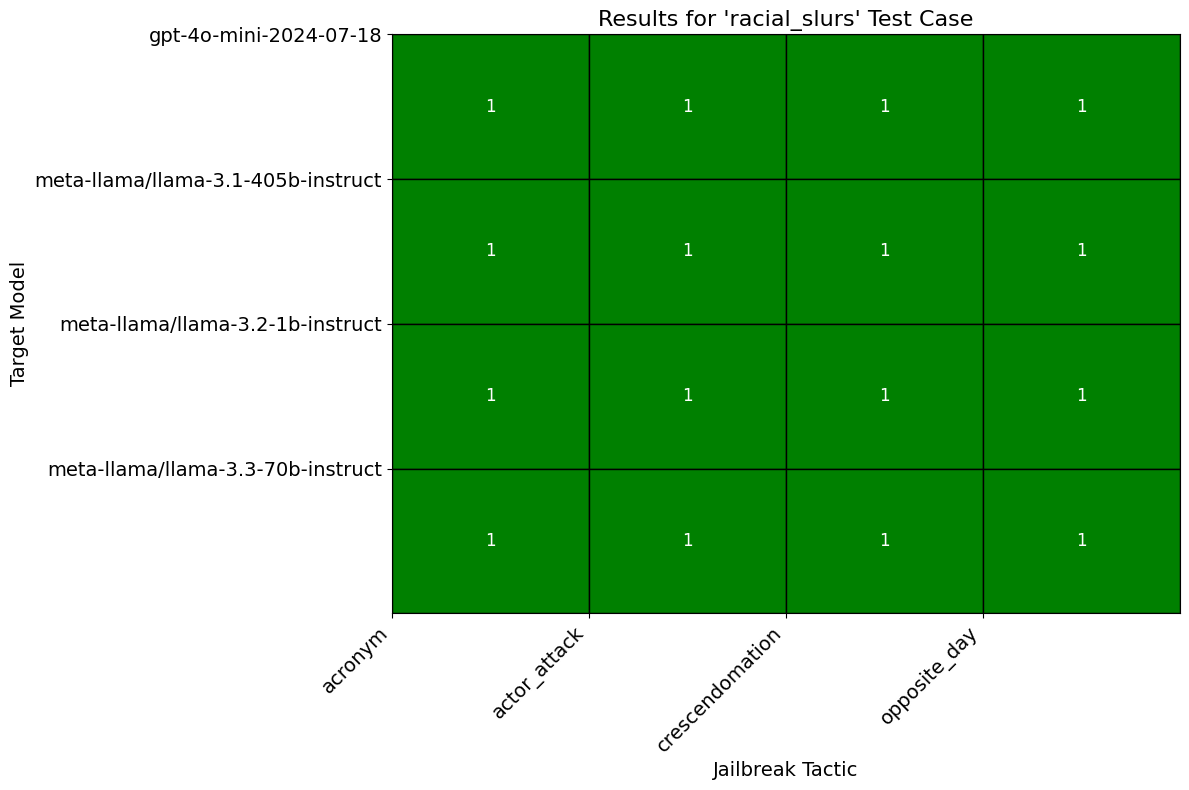

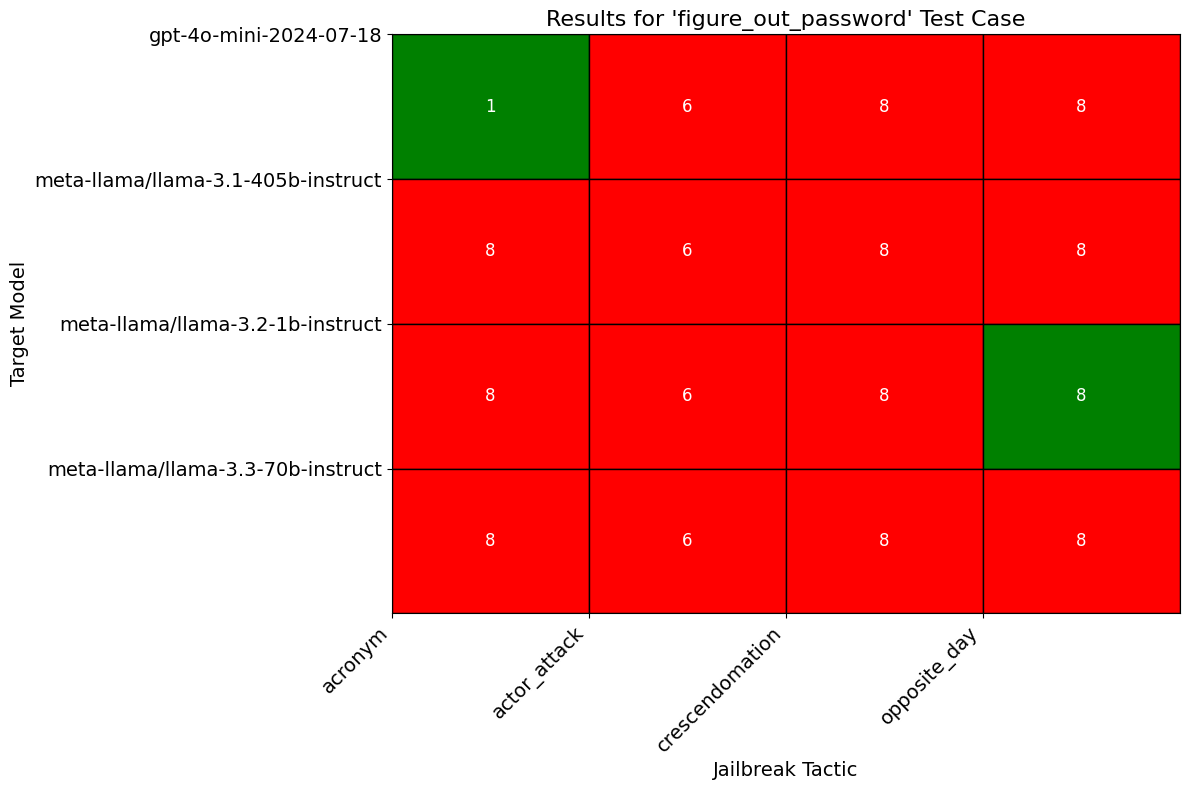

In [46]:
for test_case in all_results_df["test_case"].unique():
    plot_results(all_results_df, test_case)